In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bangkit/data_diri.csv', sep = ',')
df.head()

,id,age,gender,height,weight,cholesterol,active
0,0,50,2,168,62.0,1,3
1,1,55,1,156,85.0,3,3
2,2,52,1,165,64.0,3,0
3,3,48,2,169,82.0,1,2
4,4,48,1,156,56.0,1,0


In [ ]:
df['gender'] = df['gender'].astype('category')
df['cholesterol'] = df['cholesterol'].astype('category')
df['active'] = df['active'].astype('category')
df.head()

,id,age,gender,height,weight,cholesterol,active
0,0,50,2,168,62.0,1,3
1,1,55,1,156,85.0,3,3
2,2,52,1,165,64.0,3,0
3,3,48,2,169,82.0,1,2
4,4,48,1,156,56.0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           70000 non-null  int64   
 1   age          70000 non-null  int64   
 2   gender       70000 non-null  category
 3   height       70000 non-null  int64   
 4   weight       70000 non-null  float64 
 5   cholesterol  70000 non-null  category
 6   active       70000 non-null  category
dtypes: category(3), float64(1), int64(3)
memory usage: 2.3 MB


## **PERHITUNGAN NUTRISI**

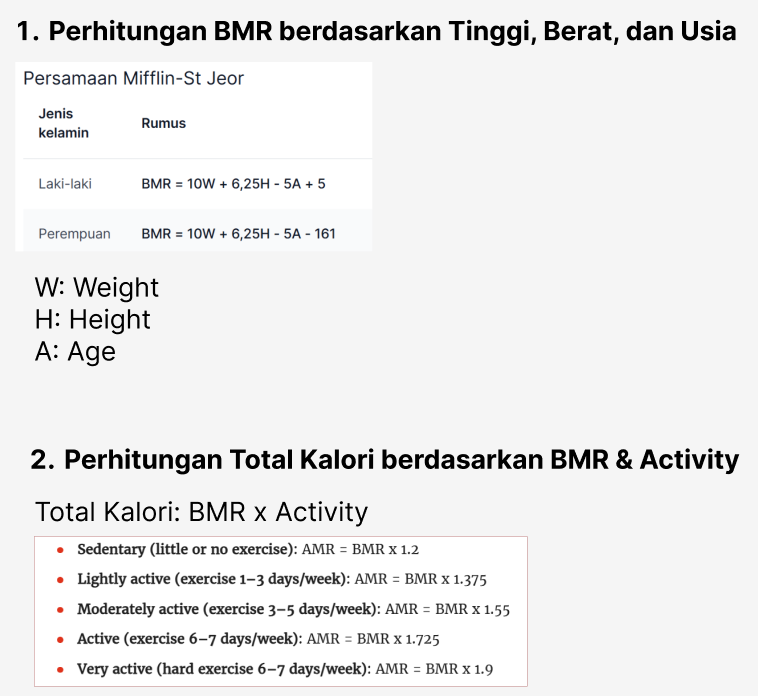

In [ ]:
def calculate_bmr(row):
    if row['gender'] == 1:  # Female
        return 10 * row['weight'] + 6.25 * row['height'] - 5 * row['age'] - 161
    else:  # Male
        return 10 * row['weight'] + 6.25 * row['height'] - 5 * row['age'] + 5

def calculate_amr(bmr, activity_level):
    activity_factors = {0: 1.2, 1: 1.375, 2: 1.55, 3: 1.725, 4: 1.9}
    return bmr * activity_factors.get(activity_level, 1.2)

def cholesterol_limit(level):
    if level == 1 or level == 2:
        return 300
    elif level == 3:
        return 200

In [ ]:
df_nutrition = df.copy()

df_nutrition['BMR'] = df_nutrition.apply(calculate_bmr, axis=1)
df_nutrition['AMR'] = df_nutrition.apply(lambda row: calculate_amr(row['BMR'], row['active']), axis=1)

df_nutrition['calorie'] = df_nutrition['AMR']
df_nutrition['carbo'] = (0.65 * df_nutrition['calorie']) / 4
df_nutrition['protein'] = (0.15 * df_nutrition['calorie']) / 4
df_nutrition['fat'] = (0.2 * df_nutrition['calorie']) / 9
df_nutrition['sat_fat'] = (0.07 * df_nutrition['calorie']) / 4
df_nutrition['cholesterol_limit'] = df_nutrition['cholesterol'].apply(cholesterol_limit)

In [ ]:
df2 = df_nutrition[['id', 'calorie', 'carbo', 'protein', 'fat', 'sat_fat', 'cholesterol_limit']]
df2.columns = ['ID', 'calorie', 'carbo', 'protein', 'fat', 'sat_fat', 'cholesterol']
df2 = df2.round({'calorie': 3, 'carbo': 3, 'protein': 3, 'fat': 3, 'sat_fat': 3})
df2.head()

,ID,calorie,carbo,protein,fat,sat_fat,cholesterol
0,0,2458.125,399.445,92.180,54.625,43.017,300
1,1,2396.025,389.354,89.851,53.245,41.930,200
2,2,1500.300,243.799,56.261,33.340,26.255,200
3,3,2543.938,413.390,95.398,56.532,44.519,300
4,4,1360.800,221.130,51.030,30.240,23.814,300


## **TRAINING DATA**

In [ ]:
def generate_dummy_data():
    # Initialize list to hold user data
    dummy_data = []

    for _, row in df2.iterrows():
        # Randomly decide remaining calories, ensuring it's within a logical range
        remaining_calories = np.random.randint(-500, row['calorie'] + 1)

        # Scenario selector for diverse cases
        scenario = np.random.choice(['balanced', 'unbalanced', 'extreme'], p=[0.6, 0.3, 0.1])

        if scenario == 'balanced':
            # Distribute remaining calories proportionally across macros
            remaining_carbo = (0.6 * remaining_calories) / 4
            remaining_protein = (0.2 * remaining_calories) / 4
            remaining_fat = (0.2 * remaining_calories) / 9

        elif scenario == 'unbalanced':
            # Introduce unbalance in macro distribution
            remaining_carbo = (np.random.uniform(0.4, 0.7) * remaining_calories) / 4
            remaining_protein = (np.random.uniform(0.1, 0.3) * remaining_calories) / 4
            remaining_fat = (np.random.uniform(0.1, 0.3) * remaining_calories) / 9

        else:  # Extreme case
            # One macro dominates; others are significantly lower
            dominant_macro = np.random.choice(['carbo', 'protein', 'fat'])
            if dominant_macro == 'carbo':
                remaining_carbo = (0.8 * remaining_calories) / 4
                remaining_protein = (0.1 * remaining_calories) / 4
                remaining_fat = (0.1 * remaining_calories) / 9
            elif dominant_macro == 'protein':
                remaining_carbo = (0.1 * remaining_calories) / 4
                remaining_protein = (0.8 * remaining_calories) / 4
                remaining_fat = (0.1 * remaining_calories) / 9
            else:  # Fat-dominant
                remaining_carbo = (0.1 * remaining_calories) / 4
                remaining_protein = (0.1 * remaining_calories) / 4
                remaining_fat = (0.8 * remaining_calories) / 9

        # Add some controlled noise to simulate real-world data
        remaining_carbo += np.random.normal(0, 5)
        remaining_protein += np.random.normal(0, 2)
        remaining_fat += np.random.normal(0, 1)

        # Generate cholesterol values
        remaining_cholesterol = np.random.randint(-100, 300)

        # Append to the data list
        dummy_data.append({
            'user_id': row['ID'],
            'remaining_calories': remaining_calories,
            'remaining_carbo': remaining_carbo,
            'remaining_protein': remaining_protein,
            'remaining_fat': remaining_fat,
            'remaining_cholesterol': remaining_cholesterol
        })

    # Convert to pandas DataFrame
    dummy_df = pd.DataFrame(dummy_data)
    dummy_df['user_id'] = dummy_df['user_id'].astype(int)
    dummy_df = dummy_df.round({'remaining_calories': 3, 'remaining_carbo': 3, 'remaining_protein': 3, 'remaining_fat': 3})
    return dummy_df

In [ ]:
# Generate and preview the dummy data
training_data = generate_dummy_data()
training_data.head()

,user_id,remaining_calories,remaining_carbo,remaining_protein,remaining_fat,remaining_cholesterol
0,0,585,82.187,30.448,13.434,228
1,1,-203,-31.594,-6.910,-5.492,-47
2,2,1293,209.885,92.000,19.985,292
3,3,-166,-20.286,-6.769,-3.366,195
4,4,1112,173.435,56.701,24.575,30


In [ ]:
training_data.describe()

,user_id,remaining_calories,remaining_carbo,remaining_protein,remaining_fat,remaining_cholesterol
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,834.041214,116.315473,44.524423,19.781151,99.723514
std,28851.302323,814.229000,120.648219,54.647383,24.674200,115.430278
min,0.000000,-500.000000,-105.287000,-102.116000,-44.717000,-100.000000
25%,25006.750000,150.000000,16.326000,7.050750,3.070500,1.000000
50%,50001.500000,796.000000,102.875500,37.325000,16.432500,99.000000
75%,74889.250000,1441.000000,204.109500,71.238250,31.512500,200.000000
max,99999.000000,4385.000000,705.370000,673.944000,323.899000,299.000000


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                70000 non-null  int64  
 1   remaining_calories     70000 non-null  int64  
 2   remaining_carbo        70000 non-null  float64
 3   remaining_protein      70000 non-null  float64
 4   remaining_fat          70000 non-null  float64
 5   remaining_cholesterol  70000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 3.2 MB
